QFT

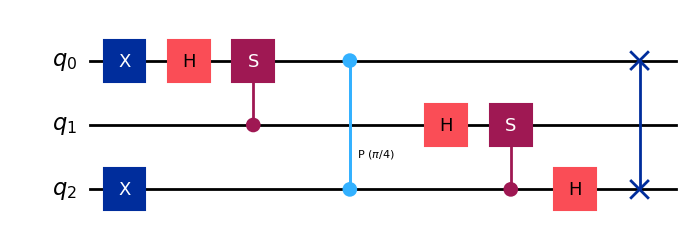

In [31]:
from qiskit import QuantumCircuit, transpile
import math
qc=QuantumCircuit(3)
qc.x(0)
qc.x(2)
qc.h(0)
qc.cs(1,0)
qc.cp(math.pi/4,2,0)
qc.h(1)
qc.cs(2,1)
qc.h(2)
qc.swap(0,2)
# qc.measure_all()
qc.draw('mpl')


In [32]:
from qiskit.quantum_info import Pauli , SparsePauliOp
#We use sparse pauli to optimise multi qubit observables , as it uses less memory
ZZZ = SparsePauliOp('ZZZ')
ZII = SparsePauliOp('ZII')
IZZ = SparsePauliOp('IZZ')

observalbles=[ZZZ, ZII,IZZ]
# string=['Z'+'I'*155]
# observ2=[SparsePauliOp(long) for long in string]



# OPTIMISATION

Estimator is used to find the average value of an observable  , for that circuit output vector state
Sampler is used to measure the qubit wire in circuits 
Transpiler is used to optimise the circuit to be able to run in hardware 
when needed to connect to ibm cloud / internet /hardware , u have to use SERVICE ;

#BACKEND

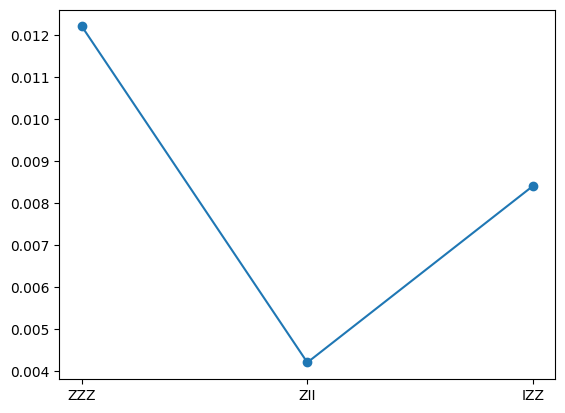

In [36]:
from qiskit_aer.primitives import Estimator

estimator= Estimator(run_options={'shots':10000})

job=estimator.run([qc]*len(observalbles), observalbles)
values=job.result().values

import matplotlib.pyplot as plt

data=['ZZZ','ZII','IZZ']
plt.plot(data,values,'-o')

## Optimising the circuit 


Both circuit and operators needs to be transpiled

In [ ]:
# for locally  , but as such need
# from qiskit_ibm_runtime import QiskitRuntimeService
# Transpiling is to make the circuit as easily executable on the backend as possible also hardware compatible ; we can use our quantum gates and circuit knowledge too for it
from qiskit import transpile
from qiskit_aer import Aer

backend_name = 'aer_simulator'
backendi = Aer.get_backend(backend_name)
qc_transpiled_1 = transpile(qc, backend=backendi, optimization_level=1)


In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
service = QiskitRuntimeService(channel='ibm_cloud')
print(service.backends())
backend_name = 'ibm_fez'
backend = service.backend(backend_name)
qc_transpiled_2 = transpile(qc, backend=backend, optimization_level=1,layout_method='trivial')  # trivial layout to avoid qubit mapping
### Applying the layout of transpiled circuit to observables too
operators_transpiled=[op.apply_layout(qc_transpiled_2.layout) for op in observalbles]



management.get:WARNING:2025-11-18 15:41:44,940: Loading default saved account


[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]


#Running on hardware

In [ ]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(mode=backend)

# job = estimator.run((qc_transpiled_2, [obs]) for obs in observ2)      # EstimatorV2 needs a list of tuples(circuit, observable)
jobs = [(qc_transpiled_2, operators_transpiled)]   # note: jobs is a list with one tuple i.e one job i.e one circuit+observables pair
job = estimator.run(jobs)
job_id = job.job_id()
print("Job ID:", job_id)
# print(results)

# values = results[0].data.evs
# print("Expectation values:", values)


Job ID: d4e4eap6dsss73b4ok6g


##POST PROCESS 

We use different cell for running job , so only need to run a job once .

In [16]:
job=service.job(job_id)


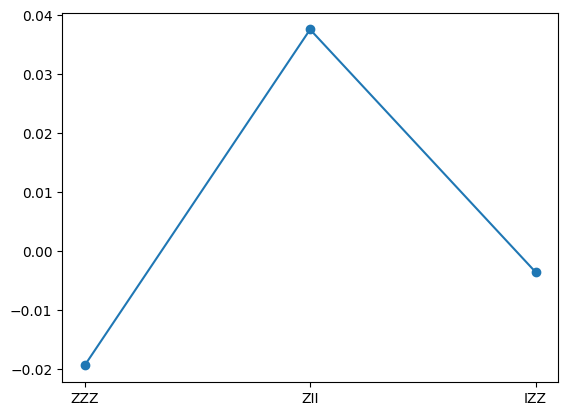

In [17]:
#PLOTTING THE RESULTS
import matplotlib.pyplot as plt
result = job.result()[0]                 # 0 cuz we passed only one set of circuqit + observables
values = result.data.evs

data=['ZZZ','ZII','IZZ']
plt.plot(data,values,'-o')